# Probabilistic Roadmap!

Create a 2D space with obstacles, and find the shortest path from a starting (x,y) position to a goal position avoiding obstacles. Shortest path is found using my implementation of Dijkstra's algorithm.

In [1]:
import random
import string

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

import shapely as sl

from scipy.stats import uniform
from scipy.spatial import Delaunay
from scipy.spatial import KDTree

# From my personal libraries
from dijkstra import BakerGraph
from dijkstra import dijkstra_with_path

Shortest Path from A to F: (14, ['A', 'C', 'B', 'D', 'F'])


### Create a list of the vertices of each obstacle in the workspace, including the boundaries of the space in x,y

In [2]:
# Set vertices of the obstacles
CB = [(0,0),(10,0),(10,10),(0,10)] # Boundary
CB1 = [(3,3),(3,4),(5,4),(5,3)]  # Rectangle
CB2 = [(7,4),(7,2),(8,2)]        # Triangle

# Polygon list!
rectangle = ((3,3),(3,4),(5,4),(5,3))
triangle = ((7,4),(7,2),(8,2))
polygons = [sl.Polygon(rectangle), sl.Polygon(triangle)]

# ALL LINE SEGMENTS MAKING UP OBSTACLES
# Rectangle
l1 = (CB1[0], CB1[3])
l2 = (CB1[3], CB1[2])
l3 = (CB1[2], CB1[1])
l4 = (CB1[1], CB1[0])

# Triangle
l5 = (CB2[1], CB2[2])
l6 = (CB2[2], CB2[0])
l7 = (CB2[0], CB2[1])

# Border
l8 = (CB[0], CB[1])
l9 = (CB[1], CB[2])
l10 = (CB[2], CB[3])
l11 = (CB[3], CB[0])

obst_lines = np.array([l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11])

# VERTICES MAKING UP OBSTACLES:
vertices = [(3,3),(3,4),(5,4),(5,3),(7,4),(7,2),(8,2)]

### Everything we need to define to plot the space and obstacles defined:

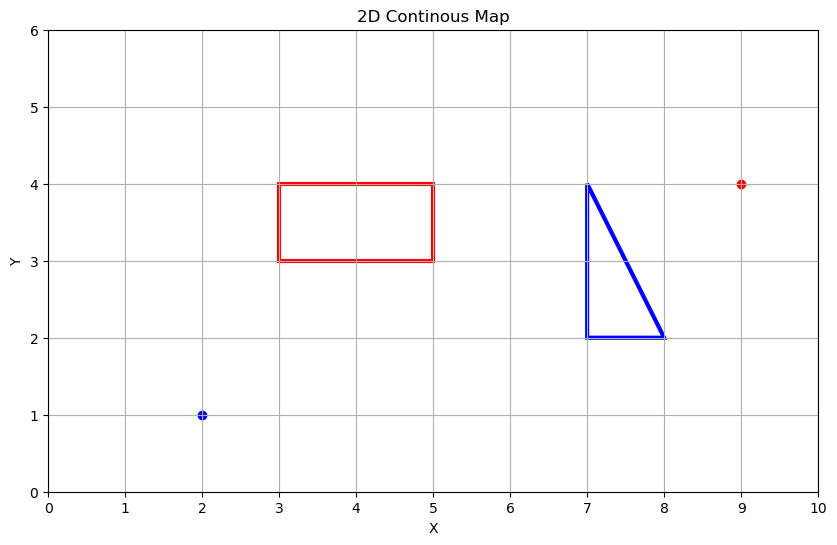

In [3]:
# Plot grid
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(range(11))
ax.set_yticks(range(7))
ax.grid(True)

# Plot rectangle
rect = Rectangle((CB1[0][0], CB1[0][1]), CB1[2][0]-CB1[0][0], CB1[2][1]-CB1[0][1], edgecolor='red', facecolor='none',linewidth=3)
ax.add_patch(rect)

# Plot triangle
triangle = Polygon(CB2, closed=True, edgecolor='blue', facecolor='none',linewidth=3)
ax.add_patch(triangle)

# Plot start and end position
qo = (2,1)
qf = (9,4)
ax.scatter(2,1,c='b')
ax.scatter(9,4,c='r')

# Show plot
plt.title('2D Continous Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Define the graph structure that the map will be stored within. I call it "BakersGraph"

In [4]:
graph = BakerGraph()

### Here's where PRM really gets started: Random points are uniformly distributed over the workspace

In [5]:

# Define the boundaries of the rectangular region
x_min, x_max = 0, 10
y_min, y_max = 0, 6
num_pts = 100

# Generate the points
x_pts = uniform.rvs(loc=x_min, scale=x_max-x_min, size=num_pts)
y_pts = uniform.rvs(loc=y_min, scale=y_max-y_min, size=num_pts)
uniform_pts = np.column_stack((x_pts, y_pts))

# defining a polygon region using Delaunay triangulation
rect = Delaunay(CB1)
tri = Delaunay(CB2)


### The uniform points are filtered based on if they are inside of obstacles

In [6]:
# Filter out points that are inside of objects

# move points from array to a list
uniform_pts_l = uniform_pts.tolist()

for pts in uniform_pts_l: # for each point in the array

    # If point exists or is on line of either obstacle, remove from list
    if (rect.find_simplex(pts) >= 0) or (tri.find_simplex(pts) >= 0):
            # remove the point
            uniform_pts_l.remove(pts)

# convert back to numpy array
uniform_pts_filtered = np.array(uniform_pts_l)

### Plotting the randomly generated points

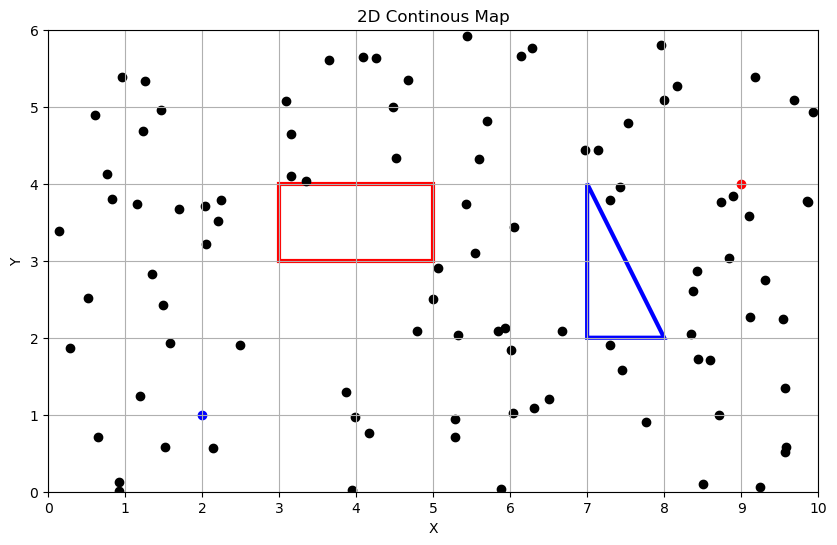

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(range(11))
ax.set_yticks(range(7))
ax.grid(True)

# Plot rectangle
rect = Rectangle((CB1[0][0], CB1[0][1]), CB1[2][0]-CB1[0][0], CB1[2][1]-CB1[0][1], edgecolor='red', facecolor='none',linewidth=3)
ax.add_patch(rect)

# Plot triangle
triangle = Polygon(CB2, closed=True, edgecolor='blue', facecolor='none',linewidth=3)
ax.add_patch(triangle)

# Plot start and end position
qo = (2,1)
qf = (9,4)
ax.scatter(2,1,c='b')
ax.scatter(9,4,c='r')

for pts in uniform_pts_filtered:
    ax.scatter(pts[0],pts[1],color='black')

# Show plot
plt.title('2D Continous Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### A random string name is generated for each point. This will serve as an identifier for each node/vertice in the map

In [8]:
# Assign each point it's own unique string name for dictionary indexing
# (From chatGPT- Question: How would I generate random strings in python for N names?)

def generate_random_name(length):
    return ''.join(random.choices(string.ascii_letters, k=length))

def generate_unique_random_names(N, name_length):
    random_names = set()  # Use a set to store unique names
    while len(random_names) < N:
        name = generate_random_name(name_length)
        random_names.add(name)
    return list(random_names)

N = len(uniform_pts_filtered)  # Number of random names to generate
name_length = 5  # Length of each random name

random_names = generate_unique_random_names(N, name_length)
print(random_names[:10])

['yGGRA', 'CWOaw', 'lbZYB', 'wghMq', 'neSej', 'wlzxG', 'vWMRU', 'OpzXU', 'daVbb', 'DXTtV']


### Each point is stored in the map, along with edges to that points neighbors. Radius of sphere of neighbors is controlled by "r".

In [9]:
# Assign each point a random name
# Find and connect nearest neighbors of each point

map_tree = KDTree(uniform_pts_filtered)

for i, pts in enumerate(uniform_pts_filtered):
    graph.add_vertex(random_names[i],pts[0],pts[1])
    graph.add_vertex_edge(random_names[i]) # adds the name to the dictionary where edges are pulled from
    neighbor_idx = map_tree.query_ball_point(x=pts, r=1.5) # returns list of indices of neighbors of x
    
    for j in range(len(neighbor_idx)):
        # add an edge for the vertex for each neighbor
        dist = sl.distance(sl.Point(uniform_pts_filtered[neighbor_idx[j]][0],uniform_pts_filtered[neighbor_idx[j]][1]),sl.Point(pts))
        
        # Simply don't add the edge if it goes through an obstacle line
        a = sl.LineString([pts, uniform_pts_filtered[neighbor_idx[j]]])
        
        # We look at all the lines of the obstacles and make sure our new segment does not cross it
        for shape in polygons:
            if (a.intersects(shape)) == False:
                graph.add_edge(random_names[i],random_names[neighbor_idx[j]], dist)

### We add in the start and end vertices to the graph, and add edges to their neighbors as well

In [10]:
# Find neighbors for the start and end vertices
endpts = [(2,1),(9,4)]
names = ['start', 'end']

for i, pts in enumerate(endpts):
    graph.add_vertex(names[i],pts[0],pts[1])
    graph.add_vertex_edge(names[i]) # adds the name to the dictionary where edges are pulled from
    neighbor_idx = map_tree.query_ball_point(x=pts, r=1.5) # returns list of indices of neighbors of x
    
    for j in range(len(neighbor_idx)):
        # add an edge for the vertex for each neighbor
        dist = sl.distance(sl.Point(uniform_pts_filtered[neighbor_idx[j]][0],uniform_pts_filtered[neighbor_idx[j]][1]),sl.Point(pts))
        
        # Simply don't add the edge if it goes through an obstacle line
        a = sl.LineString([pts, uniform_pts_filtered[neighbor_idx[j]]])
        
        # We look at all the lines of the obstacles and make sure our new segment does not cross it
        for shape in polygons:
            if (a.intersects(shape)) == False:
                graph.add_edge(names[i],random_names[neighbor_idx[j]], dist)
        

### Dijkstra is used to find the shortest path

In [11]:
# Run Dijkstra
shortest_path, path = dijkstra_with_path(map_object=graph, start_vertex='start', destination_vertex='end')
shortest_path

9.96820487900622

In [12]:
path

['start',
 'AsaAr',
 'SstPA',
 'PkItU',
 'cpdfi',
 'HMrvb',
 'lbZYB',
 'eDRdH',
 'DXTtV',
 'end']

### Plotting the lines connecting the points

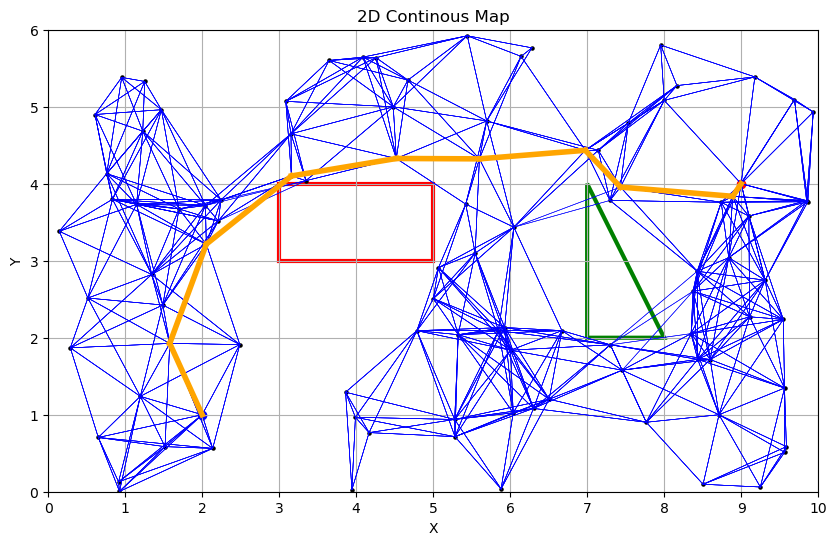

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(range(11))
ax.set_yticks(range(7))
ax.grid(True)

# Plot rectangle
rect = Rectangle((CB1[0][0], CB1[0][1]), CB1[2][0]-CB1[0][0], CB1[2][1]-CB1[0][1], edgecolor='red', facecolor='none',linewidth=3)
ax.add_patch(rect)

# Plot triangle
triangle = Polygon(CB2, closed=True, edgecolor='green', facecolor='none',linewidth=3)
ax.add_patch(triangle)

# Plot start and end position
qo = (2,1)
qf = (9,4)
ax.scatter(2,1,c='b')
ax.scatter(9,4,c='r')

for pts in uniform_pts_filtered:
    ax.scatter(pts[0],pts[1],color='black',s=5)
    
# for each node name (such as "start") in the graph, we plot lines to its neighbors
for node in graph.vertices:
    for i in range(len(graph.vertice_edges[node])):
        x1,y1 = graph.vertices[node]
        name = graph.vertice_edges[node][i][0] # gives the name of the neighbor
        x2,y2 = graph.vertices[name]
        ax.plot([x1,x2],[y1,y2],color='blue',linewidth=.4)

# Go over and replot the dijkstra path in orange       
for i in range(len(path)):
    
    x1,y1 = graph.vertices[path[i]]
    x2,y2 = graph.vertices[path[i+1]]
    ax.plot([x1,x2],[y1,y2],color='orange',linewidth=4)
    
    if path[i+1] == 'end':
        break

# Show plot
plt.title('2D Continous Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()